# MINE 4206 – Machine Learning en el modelaje y análisis de información

### Proyecto "Estimación de la duración de una tarea, dependiendo el esfuerzo"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling #funcion para ver missing values por variables en DF**
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from  sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics  
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
import mglearn
import warnings
warnings.filterwarnings('ignore')
import time
import scikitplot as skplt

In [2]:
def normalizar_var(dataset):
    num_cols = dataset.columns[dataset.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    scaler = StandardScaler()
    dataset[num_cols] = scaler.fit_transform(dataset[num_cols])
    #data_normal.head()

### En la entrega anterior hemos preparado los datos en el archivo "pSolicitudesResultado3.csv", cargamos el archivo en un panda.DataFrame

In [3]:
df_solicitudes = pd.read_csv("pSolicitudesResultado3.csv", index_col="SOLICITUD", encoding = 'ansi')

In [4]:
df_solicitudes.shape

(9399, 331)

### Tenemos 9399 registros con 331 atributos

In [5]:
df_solicitudes.sample(5)

,TIPO,AÑO,PERIODO,DURACION,P20004,P20001,P20003,P20002,P10032,P10425,...,P10335,P10612,P10387,P10389,P10617,P10616,P10341,P10340,P10273,ESFUERZO
SOLICITUD,,,,,,,,,,,,,,,,,,,,,
201881130100007448,1002,2015,6,6910210,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
201881130100013303,1002,2017,3,5925017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
201881130100016019,1001,2017,1,202131117,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201881130100011597,1002,2016,6,96010680,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
201881130100001552,1002,2016,2,2042665,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


### Revisamos los diferentes valores de los atributos

### Cada atributo que empieza con 'P', son los puntos que se deben realizar en las solicitudes. Si tiene un valor de '1' se debe revisar, por lo tanto se puede reemplazar con '0' los valores nulos, que indica que no se debe revisar.

In [6]:
df_solicitudes=df_solicitudes.fillna(0)

In [7]:
df_solicitudes.sample(5)

,TIPO,AÑO,PERIODO,DURACION,P20004,P20001,P20003,P20002,P10032,P10425,...,P10335,P10612,P10387,P10389,P10617,P10616,P10341,P10340,P10273,ESFUERZO
SOLICITUD,,,,,,,,,,,,,,,,,,,,,
201881130100003910,1001,2016,1,71932139,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201881130100011686,1002,2016,5,78000301,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
201881130100003021,1002,2017,4,195047520,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
201881130100002391,1001,2015,1,103912496,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201881130100000074,1001,2016,1,11931731,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Existe un archivo '5puntosEsfuerzo.csv' que tiene una calificación de 1 a 5, de la estimación del esfuerzo que implica la revisión de cada punto. La estimación la realizó un usuario experto

In [8]:
df_esfuerzo = pd.read_csv("5puntosEsfuerzo.csv",index_col='COD_PUNTO',  encoding = 'utf-8')

In [9]:
df_esfuerzo.shape

(349, 8)

In [10]:
df_esfuerzo.sample(5)

,COD_TIPO_PUNTO,IDE_FUNCION_VALIDACION,cod_revision_punto,TIPO_SOLICITUD,Unnamed: 5,ESFUERZO,1-5 - 1minimo 5maximo,Unnamed: 8
COD_PUNTO,,,,,,,,
10336,87927551,431042,79727234,1002,NaN,3.0,NaN,NaN
10069,87927553,401033,79727234,1001,NaN,NaN,NaN,NaN
10355,87927551,431084,79727234,1002,NaN,2.0,NaN,NaN
10343,87927551,431078,79727234,1002,NaN,3.0,NaN,NaN
10444,87927553,370009,79727234,1001,NaN,NaN,NaN,NaN


In [11]:
df_esfuerzo=df_esfuerzo.fillna(0)

In [12]:
df_esfuerzo.sample(5)

,COD_TIPO_PUNTO,IDE_FUNCION_VALIDACION,cod_revision_punto,TIPO_SOLICITUD,Unnamed: 5,ESFUERZO,1-5 - 1minimo 5maximo,Unnamed: 8
COD_PUNTO,,,,,,,,
10614,87927551,431054,79727234,1002,0.0,3.0,0,0.0
10460,87927550,401035,79727234,1001,0.0,3.0,0,0.0
10171,87927551,431029,79727234,1001,0.0,3.0,0,0.0
10245,87927551,431047,79727234,1002,0.0,3.0,0,0.0
10326,87927551,370017,79727234,1002,0.0,3.0,0,0.0


### Con estos datos del esfuerzo que implica cada atributo punto 'P', realizaremos un calculo de esfuerzo por solicitud. 
### Buscaremos por cada registro cuales atributos 'P' tienen un valor de '1', luego buscaremos el esfuerzo de dicho 'P' y sumaremos todos los valores de los atributos 'P'.
### De esta manera transformaremos 225 atributos, en uno solo. 

In [13]:
col_names = df_solicitudes.columns
col_names = col_names[4:].drop('ESFUERZO')
col_names

Index(['P20004', 'P20001', 'P20003', 'P20002', 'P10032', 'P10425', 'P30000',
       'P10161', 'P10162', 'P10444',
       ...
       'P10294', 'P10335', 'P10612', 'P10387', 'P10389', 'P10617', 'P10616',
       'P10341', 'P10340', 'P10273'],
      dtype='object', length=326)

In [14]:
new_df_solicitudes= df_solicitudes[['TIPO','AÑO','PERIODO','DURACION','ESFUERZO']]

In [15]:
new_df_solicitudes.shape

(9399, 5)

In [16]:
new_df_solicitudes.head(5)

,TIPO,AÑO,PERIODO,DURACION,ESFUERZO
SOLICITUD,,,,,
201881130100000003,1002,2017,1,203998355,0.0
201881130100000007,1002,2017,3,27959361,0.0
201881130100000002,1002,2017,3,7889693,0.0
201881130100000016,1001,2016,1,206060194,0.0
201881130100000018,1002,2016,6,117021116,0.0


In [17]:
df_esfuerzo.head()

,COD_TIPO_PUNTO,IDE_FUNCION_VALIDACION,cod_revision_punto,TIPO_SOLICITUD,Unnamed: 5,ESFUERZO,1-5 - 1minimo 5maximo,Unnamed: 8
COD_PUNTO,,,,,,,,
20004,87927553,0,79727234,1001,0.0,0.0,0,0.0
20001,87927553,0,79727234,1001,0.0,0.0,0,0.0
20003,87927553,0,79727234,1001,0.0,0.0,0,0.0
20002,87927553,0,79727234,1001,0.0,0.0,0,0.0
10032,87927550,370008,79727233,1001,0.0,2.0,0,0.0


In [18]:
for ind,row in df_solicitudes.iterrows(): 
    #print("row++ :",row)
    val=0
    for col in col_names:
        if(row[col]>0):
            punto=col[1:]            
            punto=int(punto)
            #print(" row[col] " , col, "  Valor ", punto)
            temp=df_esfuerzo.at[punto,'ESFUERZO']
            #print("Encontro", punto,' funcion=',funcion)
            #print("Encontro", punto,' temp=',temp)
            if (isinstance(temp,np.ndarray)):
                #print(temp)
                temp=temp[0]
            val+=temp
     #print(ind,'Esfuerzo=',val)
    new_df_solicitudes.at[ind,'ESFUERZO']=val 
               

La nueva tabla queda con 6 atributos

In [19]:
new_df_solicitudes.head()

,TIPO,AÑO,PERIODO,DURACION,ESFUERZO
SOLICITUD,,,,,
201881130100000003,1002,2017,1,203998355,16.0
201881130100000007,1002,2017,3,27959361,16.0
201881130100000002,1002,2017,3,7889693,26.0
201881130100000016,1001,2016,1,206060194,11.0
201881130100000018,1002,2016,6,117021116,26.0


In [20]:
pd.unique(new_df_solicitudes['ESFUERZO'])

array([16., 26., 11., 46., 10., 36., 29., 19., 22., 14.,  8., 31., 34.,
        9., 17., 25.,  5., 13., 28., 18., 42., 39., 21., 15., 12., 32.,
       35., 38., 41., 23., 49., 20., 33., 44., 55., 37., 30., 45., 43.,
       48.,  7., 40., 27., 47., 58., 79., 81., 52., 50., 24., 78., 53.,
       51., 63., 77., 54., 94., 57., 66., 90., 76., 92., 60., 85., 59.,
       56., 80., 61., 65., 96., 71., 91., 62., 64., 74., 72., 86., 69.,
       68., 70., 75.])

### Cargamos el archivo que acabamos de crear "pSolicitudesResultado4.csv", teniendo en cuenta que la columna 'SOLICITUD' es un consecutivo lo cargaremos como indice del dataFrame.
### La duración será la variable que vamos a predecir. Esta es una variable continua por lo que tiene sentido pensar en una regresión

#### Guardamos la nueva tabla en el archivo "pSolicitudesResultado4.csv"

In [21]:
df_solicitudes = pd.read_csv("pSolicitudesResultado4.csv", encoding = 'utf-8')

In [22]:
df_solicitudes.head()

,SOLICITUD,TIPO,AÑO,PERIODO,DURACION,ESFUERZO
0,201881130100000003,1002,2017,1,203998355,16.0
1,201881130100000007,1002,2017,3,27959361,16.0
2,201881130100000002,1002,2017,3,7889693,26.0
3,201881130100000016,1001,2016,1,206060194,11.0
4,201881130100000018,1002,2016,6,117021116,26.0


# ANALISIS DE VARIABLES

##  Analisis de distribucion  variables "ESFUERZO" y  "DURACION". 

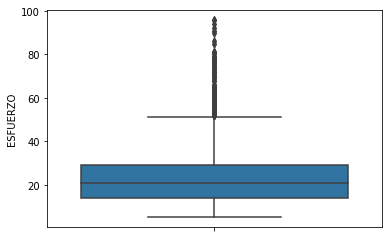

In [23]:
sns.boxplot(y=df_solicitudes.ESFUERZO)
plt.show()

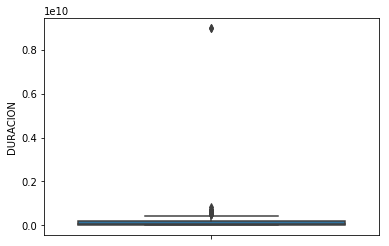

In [24]:
sns.boxplot(y=df_solicitudes.DURACION)
plt.show()

## Se observan outliers en las variables por lo cual se eliminan

In [25]:
valor_max = df_solicitudes.ESFUERZO.quantile(0.75) + (1.5 * (df_solicitudes.ESFUERZO.quantile(0.75) - df_solicitudes.ESFUERZO.quantile(0.25)))
df_solicitudes = df_solicitudes.drop(df_solicitudes[df_solicitudes.ESFUERZO > valor_max].index)

In [26]:
valor_max = df_solicitudes.DURACION.quantile(0.75) + (1.5 * (df_solicitudes.DURACION.quantile(0.75) - df_solicitudes.DURACION.quantile(0.25)))
df_solicitudes = df_solicitudes.drop(df_solicitudes[df_solicitudes.DURACION > valor_max].index)

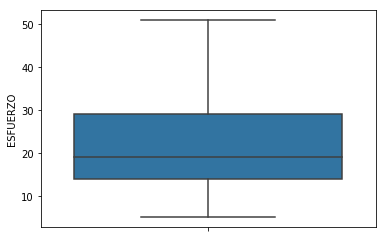

In [27]:
sns.boxplot(y=df_solicitudes.ESFUERZO)
plt.show()

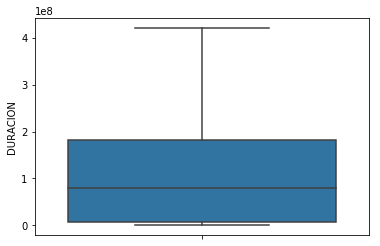

In [28]:
sns.boxplot(y=df_solicitudes.DURACION)
plt.show()

### Comportamiento variables

In [29]:
pandas_profiling.ProfileReport(df_solicitudes)

Number of variables,7
Number of observations,9164
Total Missing (%),0.0%
Total size in memory,501.2 KiB
Average record size in memory,56.0 B
Numeric,6
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


### Se Observa una fuerte correlación entre las variables Tipo-Perido, para efectos de análisis y dado que se obtuvieron,  luego de los procesos de agregación en pasos anteriores pocas variable, se mantienen dichas variables   

### Grafico la duración vs el esfuerzo 

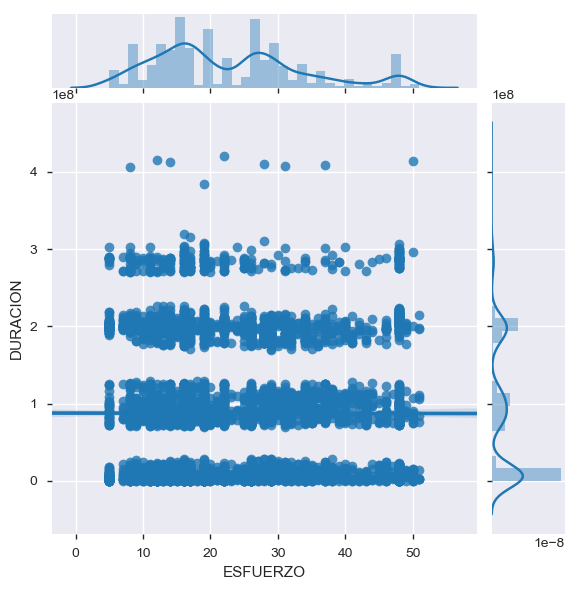

In [30]:
sns.jointplot(x='ESFUERZO', y='DURACION', data=df_solicitudes, kind='reg')
plt.show()

## Se observa que para los diferentes valores de "Esfuerzo", hay rangos de "Duracion" que van de valores pequeños hasta valores muy grandes con un comportamiento casi discreto, lo que hace que los rangos se han amplios y en cierta forma se 'traslapen'   para los diferentes valores de "Esfuerzo"


# IMPLEMENTACION MODELOS

## Analisis inicial mediante  Regresion Lineal

### Creación del set de datos de entrenamiento y test, para X se elimina la variable "Duracion" (Clase) y la Variable ID "Solicitud"

In [31]:
X = df_solicitudes.drop(['DURACION','SOLICITUD'], axis=1)
y = df_solicitudes['DURACION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)  

In [32]:
y = df_solicitudes['DURACION']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)  

In [34]:
lg = LinearRegression()
lg.fit(X_train, y_train) 
y_pred = lg.predict(X_test)  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Training set score: {:.2f}".format(lg.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lg.score(X_test, y_test)))

Mean Absolute Error: 70878842.05740124
Mean Squared Error: 6967875591239832.0
Root Mean Squared Error: 83473801.82572153
Training set score: 0.00
Test set score: 0.01


### Se observa que con simple regresión lineal , los resultados son muy malos y el  modelo no se ajusta a los datos obtenidos.
## Se prueba realizando transformación Polinomial de grado 1 a 16 de los datos para ver si hay mejor ajuste. 

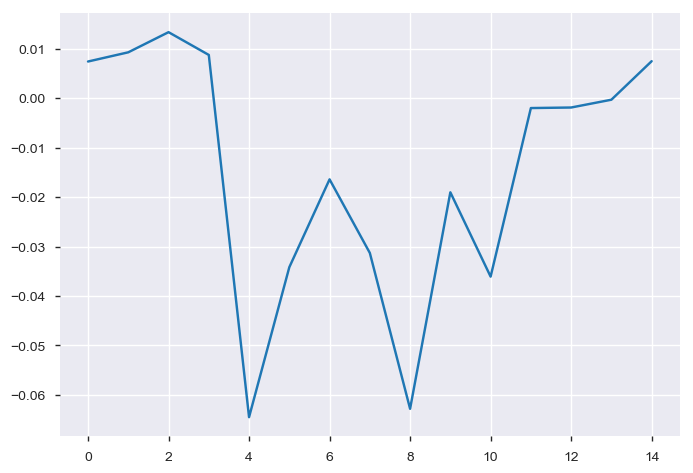

In [35]:
resultados_regpol = []
for grd in np.arange(1, 16):
    poly = PolynomialFeatures(degree=grd)
    X_ = poly.fit_transform(X_train)
    X_test_ = poly.fit_transform(X_test)
    lg = LinearRegression()
    lg.fit(X_, y_train)
    lg.coef_
    resultados_regpol.append(lg.score(X_test_, y_test))
plt.plot(resultados_regpol)
plt.show()

### Como se esperaba los resultados obtenidos con la transformación polinomial tampoco arrojan métricas positivas, mejor rendimiento que se obtendría seria  cerca del 0,02%.

## Analisis como problema de Clasificacion

### Se crea una nueva columna llamada CLASE que tendrá 0, 1, 2, 3, 4 de acuerdo a los grupos "Duracion"

In [36]:
def f(fila):
    if fila.DURACION <= .5e8:
        val = '0'
    elif fila.DURACION > .5e8 and fila.DURACION <= 1.5e8:
        val = '1'
    elif fila.DURACION > 1.5e8 and fila.DURACION <= 2.5e8:
        val = '2'
    elif fila.DURACION > 2.5e8 and fila.DURACION <= 3.5e8:
        val = '3'
    else:
        val = '4'
    return val
df_solicitudes.insert(1, 'CLASE', df_solicitudes.apply(f, axis=1))

In [37]:
df_solicitudes.head()

,SOLICITUD,CLASE,TIPO,AÑO,PERIODO,DURACION,ESFUERZO
0,201881130100000003,2,1002,2017,1,203998355,16.0
1,201881130100000007,0,1002,2017,3,27959361,16.0
2,201881130100000002,0,1002,2017,3,7889693,26.0
3,201881130100000016,2,1001,2016,1,206060194,11.0
4,201881130100000018,1,1002,2016,6,117021116,26.0


### Distribucion de las clases

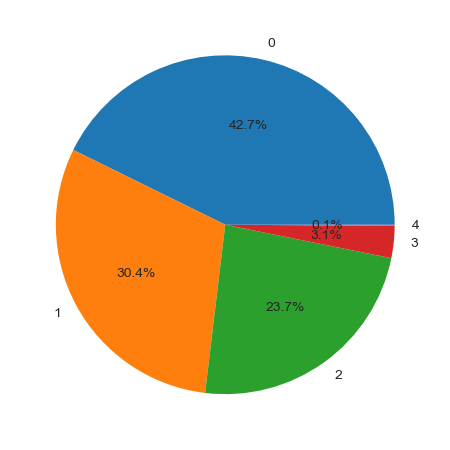

In [38]:
plt.pie(list(df_solicitudes.CLASE.value_counts()), labels=list(df_solicitudes.CLASE.value_counts().index), autopct='%1.1f%%')
plt.show()

### Se unifican las clases pequeñas, por no ser representativas y se unifican a la clase 2., se dejan solo 3 clases


In [39]:
def f(fila):
    if int(fila.CLASE) >= 3:
        return '2'
    else:
        return fila.CLASE
    return val
df_solicitudes.insert(1, 'CLASE_NEW', df_solicitudes.apply(f, axis=1))

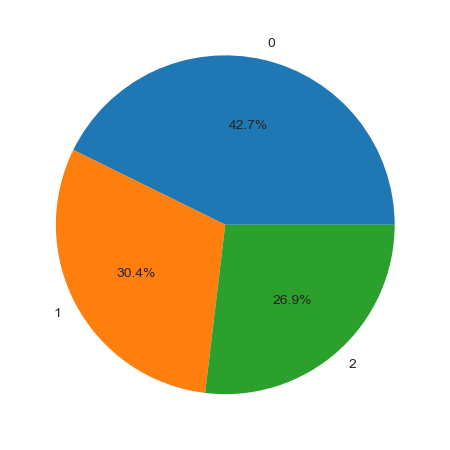

In [40]:
plt.pie(list(df_solicitudes.CLASE_NEW.value_counts()), labels=list(df_solicitudes.CLASE_NEW.value_counts().index), autopct='%1.1f%%')
plt.show()

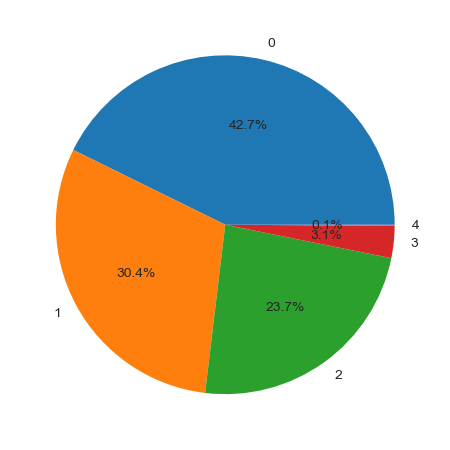

In [41]:
plt.pie(list(df_solicitudes.CLASE.value_counts()), labels=list(df_solicitudes.CLASE.value_counts().index), autopct='%1.1f%%')
plt.show()

In [42]:
df_solicitudes = df_solicitudes.drop(['CLASE'],axis =1)

In [43]:
df_solicitudes = df_solicitudes.drop(['DURACION'],axis =1)

In [44]:
df_solicitudes.head()

,SOLICITUD,CLASE_NEW,TIPO,AÑO,PERIODO,ESFUERZO
0,201881130100000003,2,1002,2017,1,16.0
1,201881130100000007,0,1002,2017,3,16.0
2,201881130100000002,0,1002,2017,3,26.0
3,201881130100000016,2,1001,2016,1,11.0
4,201881130100000018,1,1002,2016,6,26.0


## Analisis mediante  RandomForest

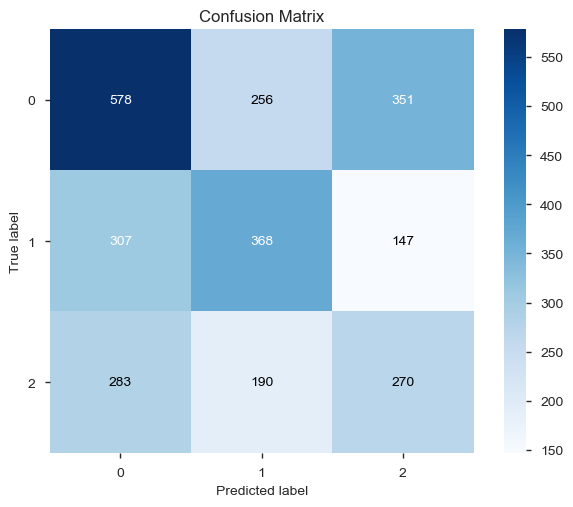

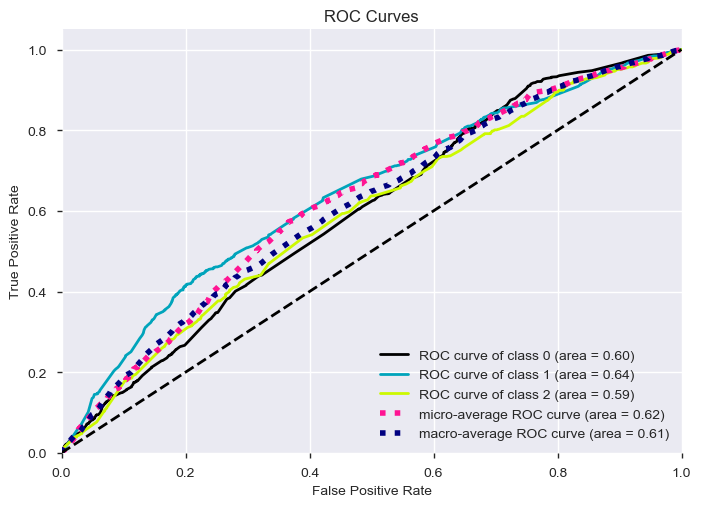

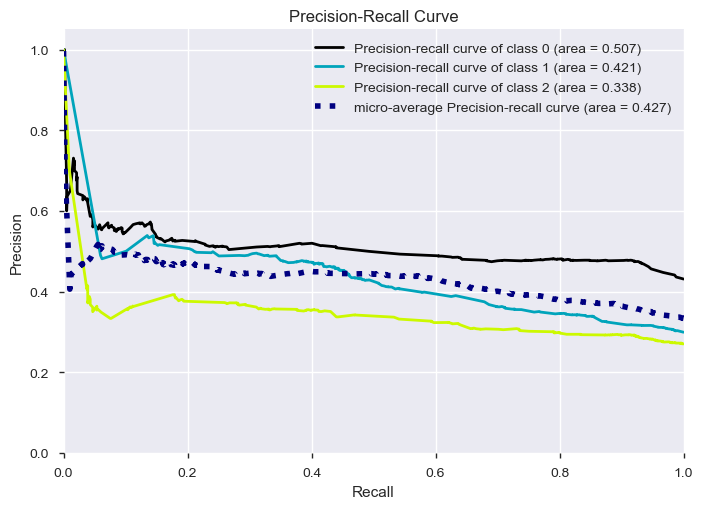

Precisión de la clase 0: 0.49
Recall de la clase 0: 0.49
F1 de la clase 0: 0.49
Precisión de la clase 1: 0.45
Recall de la clase 1: 0.45
F1 de la clase 1: 0.45
Precisión de la clase 2: 0.35
Recall de la clase 2: 0.36
F1 de la clase 2: 0.36


In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_solicitudes.drop(['CLASE_NEW'], axis=1), df_solicitudes['CLASE_NEW'], test_size=0.30, random_state=42)
rndm_frst = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
rndm_frst.fit(X_train, y_train)
y_pred = rndm_frst.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.show()
predicted_probas = rndm_frst.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()
skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
plt.show()

for i in range(3):
    print('Precisión de la clase {}: {}'.format(i, round(precision_score(y_test, y_pred, labels=[str(i)], average='micro'), 2)))
    print('Recall de la clase {}: {}'.format(i, round(recall_score(y_test, y_pred, labels=[str(i)], average='micro'), 2)))
    print('F1 de la clase {}: {}'.format(i, round(f1_score(y_test, y_pred, labels=[str(i)], average='micro'), 2)))


### Se observa que al tratar de resolver el problema mediante clasificación "RandomForest" los resultados no son muy optimistas de menos del 50% para la mayoría de las métricas evaluadas.
### De los resultados obtenidos con la curva ROC se puede observar que el área obtenida para la clase 0 es de 60%, clase 1  de 64% , y clase 2 de 59%

### Visualizacion de las tres clase con TSNE

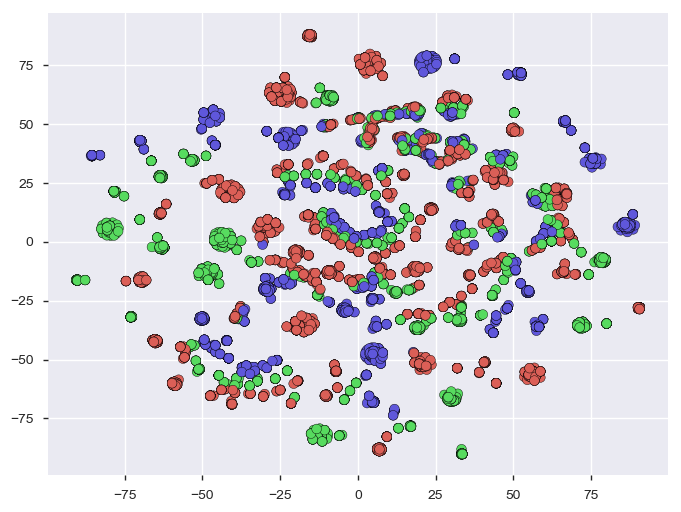

In [46]:
t_sne = TSNE(n_components=2, random_state=42).fit_transform(df_solicitudes)
plt.figure(figsize=(8, 6))
palette = np.array(sns.color_palette("hls", 3))
plt.scatter(t_sne[:, 0], t_sne[:, 1], c=palette[df_solicitudes['CLASE_NEW'].astype(np.int)], edgecolors='k')
plt.show()

## Resultados que aún no son satisfactorios de acuerdo con los objetivos  planteados inicialmente en el proyecto. 

### Se valida información con los expertos sobre cómo se generó la variable "Duracion", encontrando que tiene relación con una casuística del negocio donde se  asigna una "Prioridad" a las solicitudes entrantes , la cual puede cambiar en cualquier momento , haciendo que los tiempos se van alterados, extendiéndose o acortándose de acuerdo con la prioridad asignada.

###  Se deriva una nueva variable  teniendo en cuenta la prioridad y el  esfuerzo en atender una solicitud, la cual llamaremos "DURACION".

### La variable "DURACION"  afectada por la prioridad se normaliza y para efectos practicos se renombra como "PRIORIDAD


# ANALISIS DE NUEVOS RESULTADOS 

In [124]:
df = pd.read_csv("pSolicitudesResultado4-Real.csv",  sep=";" , decimal=",", encoding = 'utf-8')

In [125]:
df.shape

(9399, 6)

In [126]:
df.head()

,TIPO,AÑO,PERIODO,PRIORIDAD,ESFUERZO,DURACION
0,1001,2016,1,463,5,3.1
1,1001,2015,1,801,5,3.1
2,1001,2015,1,1232,5,3.1
3,1001,2015,1,8853,5,3.1
4,1001,2016,1,10290,5,3.1


In [127]:
df.dtypes

TIPO           int64
AÑO            int64
PERIODO        int64
PRIORIDAD      int64
ESFUERZO       int64
DURACION     float64
dtype: object

### Preparacion de Datos

In [128]:
#Eliminacion deOutliers - Duracion - Dificultad - Esfuerzo

valor_max = df.DURACION.quantile(0.75) + (1.5 * (df.DURACION.quantile(0.75) - df.DURACION.quantile(0.25)))
df = df.drop(df[df.DURACION > valor_max].index)

valor_max = df.PRIORIDAD.quantile(0.75) + (1.5 * (df.PRIORIDAD.quantile(0.75) - df.PRIORIDAD.quantile(0.25)))
df = df.drop(df[df.PRIORIDAD > valor_max].index)

valor_max = df.ESFUERZO.quantile(0.75) + (1.5 * (df.ESFUERZO.quantile(0.75) - df.ESFUERZO.quantile(0.25)))
df = df.drop(df[df.ESFUERZO > valor_max].index)

In [129]:
scaler = preprocessing.MinMaxScaler()
df['PRIORIDAD']=scaler.fit_transform(df[['PRIORIDAD']].values)


In [130]:
df.head()

,TIPO,AÑO,PERIODO,PRIORIDAD,ESFUERZO,DURACION
0,1001,2016,1,1.806318e-07,5,3.1
1,1001,2015,1,1.311253e-06,5,3.1
2,1001,2015,1,2.752962e-06,5,3.1
3,1001,2015,1,2.824546e-05,5,3.1
4,1001,2016,1,3.305227e-05,5,3.1


In [131]:
df.describe()

,TIPO,AÑO,PERIODO,PRIORIDAD,ESFUERZO,DURACION
count,8875.000000,8875.000000,8875.000000,8875.000000,8875.00000,8875.000000
mean,1001.512451,2016.222535,2.623549,0.276953,22.08169,32.770175
std,0.499873,0.662894,2.016142,0.268729,10.46411,22.467761
min,1001.000000,2012.000000,1.000000,0.000000,5.00000,3.100000
25%,1001.000000,2016.000000,1.000000,0.020238,14.00000,13.800000
50%,1002.000000,2016.000000,1.000000,0.264202,19.00000,25.600000
75%,1002.000000,2017.000000,4.000000,0.418040,29.00000,47.900000
max,1002.000000,2018.000000,6.000000,1.000000,51.00000,105.800000


In [132]:
df.head()

,TIPO,AÑO,PERIODO,PRIORIDAD,ESFUERZO,DURACION
0,1001,2016,1,1.806318e-07,5,3.1
1,1001,2015,1,1.311253e-06,5,3.1
2,1001,2015,1,2.752962e-06,5,3.1
3,1001,2015,1,2.824546e-05,5,3.1
4,1001,2016,1,3.305227e-05,5,3.1


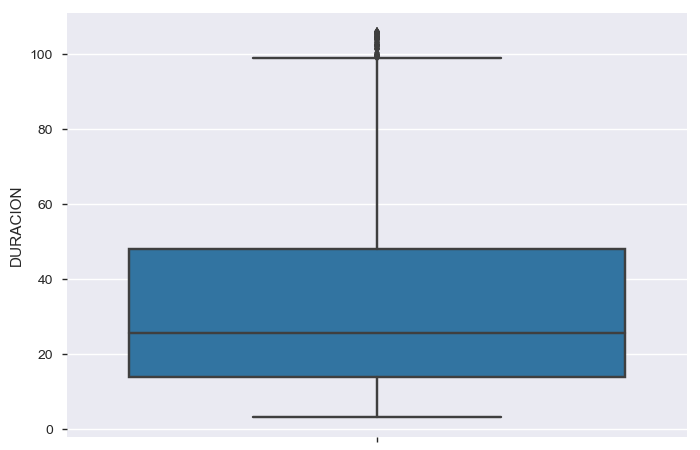

In [133]:
sns.boxplot(y=df.DURACION)
plt.show()

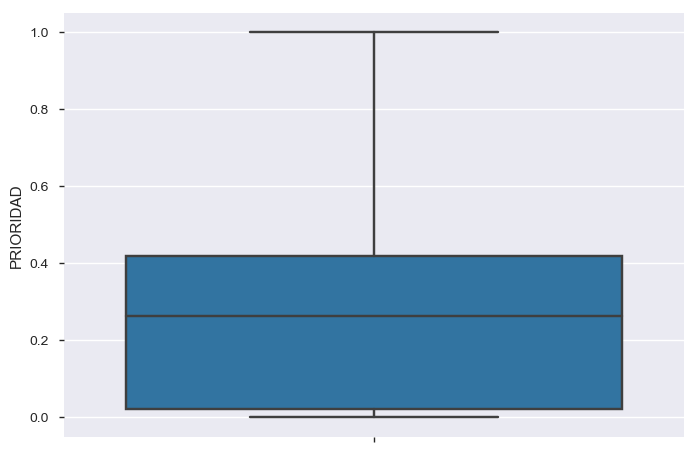

In [134]:
sns.boxplot(y=df.PRIORIDAD)
plt.show()

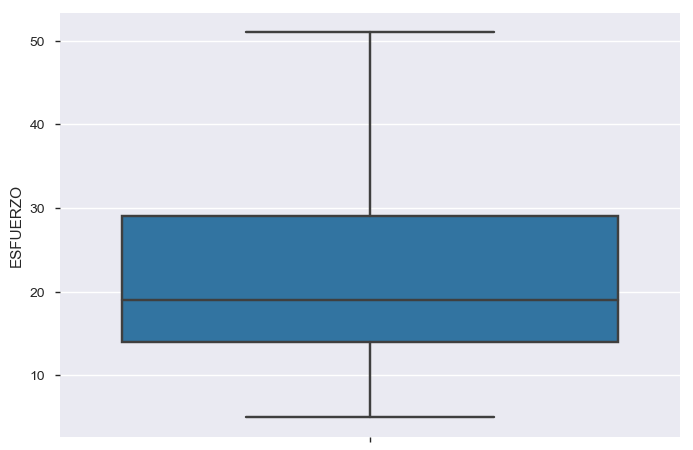

In [135]:
sns.boxplot(y=df.ESFUERZO)
plt.show()

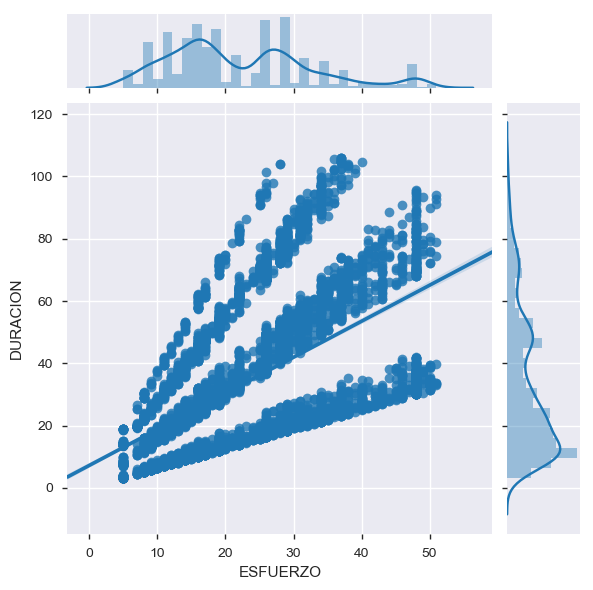

In [136]:
sns.jointplot(x='ESFUERZO', y='DURACION', data=df, kind='reg')
plt.show()

## Se observa que las mediciones en general  son más ajustas en cuanto  que para menor esfuerzo menor duración y a mayor esfuerzo mayor duración, a pesar de que se conserva la tendencia  a tener rangos discretos para los diferentes niveles de esfuerzo.

## Obtener set da datos de entrenamiento y Test

In [137]:
X = df.drop(['DURACION'], axis=1)
y = df['DURACION']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)  

In [138]:
X.shape

(8875, 5)

In [139]:
y.shape

(8875,)

In [140]:
X.head()

,TIPO,AÑO,PERIODO,PRIORIDAD,ESFUERZO
0,1001,2016,1,1.806318e-07,5
1,1001,2015,1,1.311253e-06,5
2,1001,2015,1,2.752962e-06,5
3,1001,2015,1,2.824546e-05,5
4,1001,2016,1,3.305227e-05,5


## Regresion Lineal 

In [153]:
lg1 = LinearRegression()
modelo = lg1.fit(X_train, y_train)
modelo.score(X_test,y_test)

0.8745498771586999

In [156]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.8745498771586999

## Se observa un score  aceptable de 87% de ajutes en el modelo lineal  bajo las  nuevas condiciones  de los datos.

### Algunas Metricas

In [149]:
#from sklearn import metrics  
y_pred = lg1.predict(X_test)  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Training set score: {:.2f}".format(lg1.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lg1.score(X_test, y_test)))

Mean Absolute Error: 6.035011705501186
Mean Squared Error: 64.2165827411675
Root Mean Squared Error: 8.013524988490865
Training set score: 0.88
Test set score: 0.87


In [143]:
y_pred

array([45.72678334, 37.68240368, 72.10780797, ..., 15.21754368,
       -4.06810386, 28.81946304])

### Como resultado de la metricas se obsreva que el Score para el set datos de entranmiento y para el set de datos de pruebas son muy cercanos. El calculo del error absoluto y cuadrado pueden ser conciderados como altos , para aun asi el moelo puede dar un buen desempeño en la predicion.


In [148]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(25)
df.head()

,TIPO,AÑO,PERIODO,PRIORIDAD,ESFUERZO,DURACION
0,1001,2016,1,1.806318e-07,5,3.1
1,1001,2015,1,1.311253e-06,5,3.1
2,1001,2015,1,2.752962e-06,5,3.1
3,1001,2015,1,2.824546e-05,5,3.1
4,1001,2016,1,3.305227e-05,5,3.1


# Visualizacion De Resultados

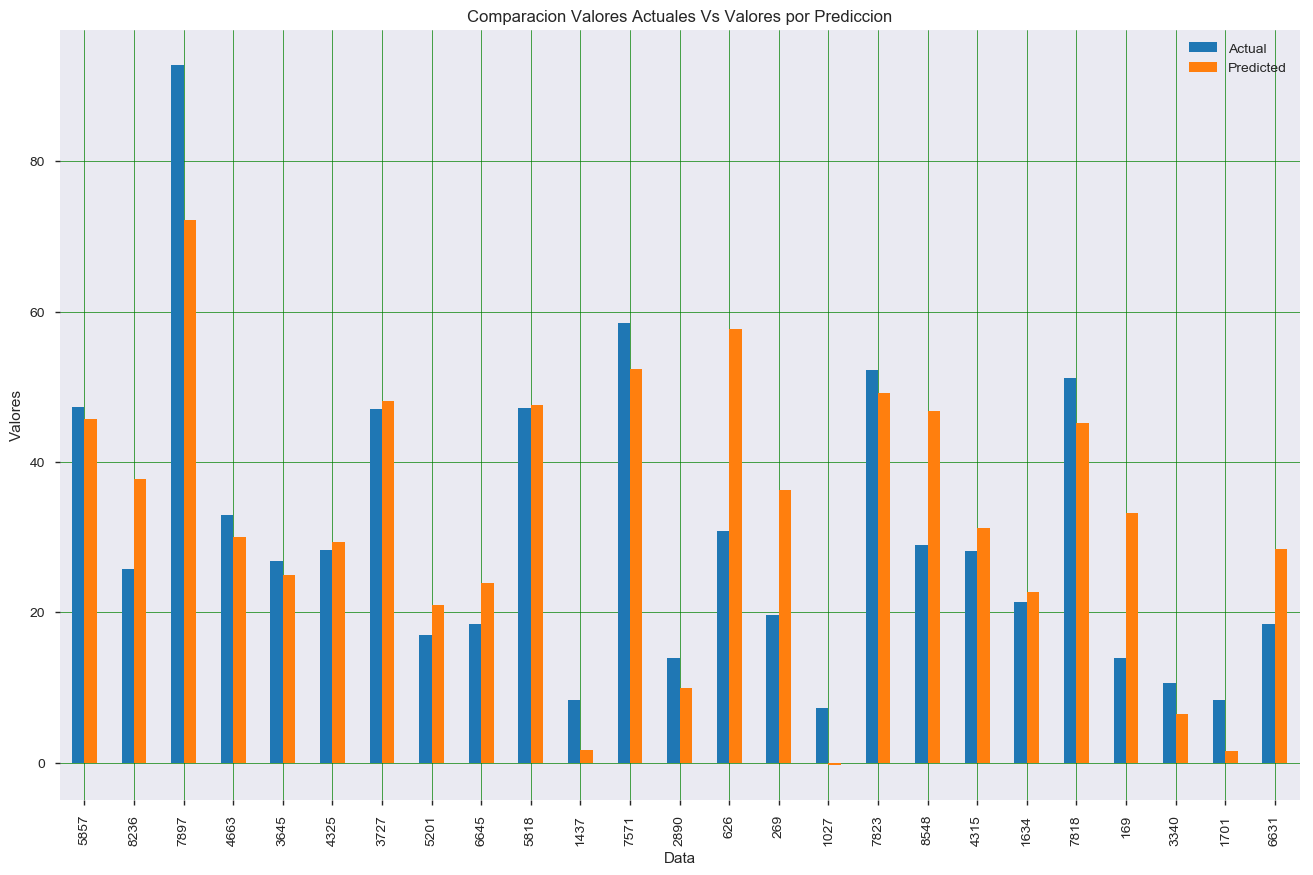

In [145]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df1.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparacion Valores Actuales Vs Valores por Prediccion')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.show()

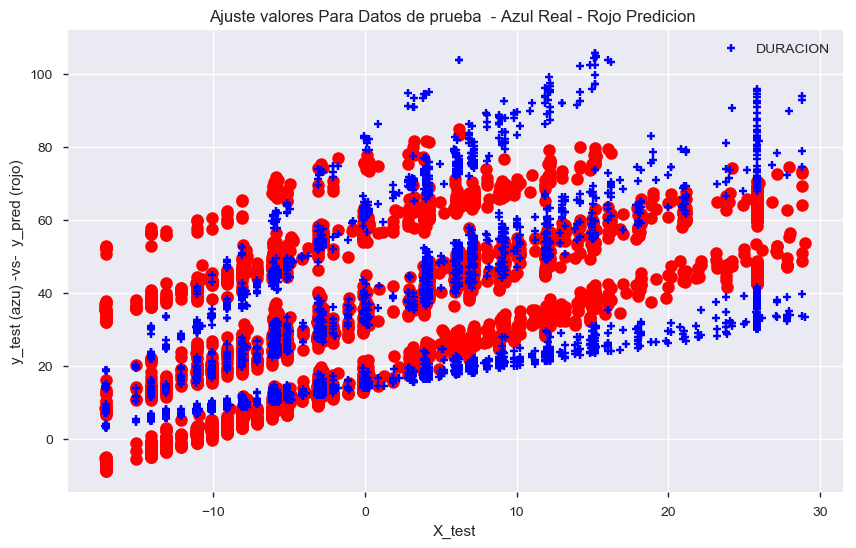

In [146]:
pca = PCA(n_components=1)
x1_test = pca.fit_transform(X_test)

# visualization
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x1_test,lg1.predict(X_test), linewidth=2, color='red')
ax.scatter(x1_test, y_test, s=30, c='blue', marker='+', zorder=10)
plt.legend()
plt.title('Ajuste valores Para Datos de prueba  - Azul Real - Rojo Predicion ')
plt.xlabel('X_test')
plt.ylabel('y_test (azu) -vs-  y_pred (rojo)')
plt.show();



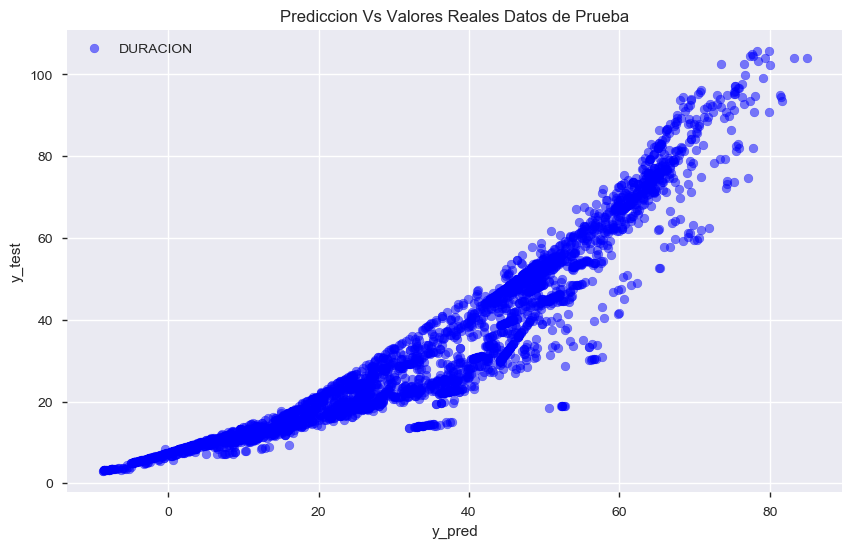

In [147]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(lg1.predict(X_test), y_test,c='b',s=40,alpha=0.5)
#ax.scatter(lg1.predict(X_test), lg1.predict(X_test)-y_test, c='g',s=40)
plt.legend()
plt.title('Prediccion Vs Valores Reales Datos de Prueba')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show();

# CONCLUSIONES:

## De acuerdo con los resultados obtenidos, se observa que a pesar de tener un score cercano al 87% y de haber realizado un gran trabajo de afinamiento de datos, es necesario recurrir nuevamente al experto de negocio para validar la forma de generar los valores “DURACION” y de identificar por que se comportan de manera discreta en algunos rangos de la data.
## Durante la realización del proyecto se evidencio el potencial de Machine Learning   para dar soluciones reales a problemas reales de la industria.
## Como guía de buena practica es muy importante contara con el apoyo del experto, estar en continuo contacto con él y desarrollar un vocabulario común, unificado con los integrantes del grupo.
## Como guía de lecciones aprendidas, para llevar acabo el proyecto de ML en la industria es necesario contra con el apoyo deicidio de la organización y tener la facilidad de acceso a los datos y fuentes de los mismos.
## Frente a los objetivos del negocio planteados inicialmente, el modelo propuesto permitirá establecer con cierto grado de certeza el esfuerzo que demandaría atender una solicitud determinada dependiendo de sus características, lo que permitirá realizar estimativos sobre las cargara reales de trabajo y la asignación mas balanceada de las mismas.
## Para incorporar el modelo al sistema operativo de la organización,  es necesario crear algunos interfaces con otros servicios como el de asignación de tareas, cronogramas de ejecución y revisión de resultados automáticos,  como también  ajustar los tiempos de predicción a las diferentes casuísticas presentadas en el flujo de la operación.


In [78]:
#bajar modelo
from joblib import dump, load
dump(modelo, 'modelo.joblib') 

['modelo.joblib']

In [79]:
# load the model from disk
from sklearn.externals import joblib
loaded_model = load('modelo.joblib')
result = loaded_model.score(X_test, y_test)
print(result)

0.8745498771586999


In [80]:
print(loaded_model.predict(X_test))

[45.72678334 37.68240368 72.10780797 ... 15.21754368 -4.06810386
 28.81946304]


### import pickle

In [82]:
#bajar
import pickle
pickle.dump(modelo, open('modelo_gr.sav', 'wb'))

In [83]:
##Cargar
loaded_modelo = pickle.load(open('modelo_gr.sav', 'rb'))
print(loaded_modelo.predict(X_test))

[45.72678334 37.68240368 72.10780797 ... 15.21754368 -4.06810386
 28.81946304]


In [86]:
X_test.head(1)

,TIPO,AÑO,PERIODO,PRIORIDAD,ESFUERZO
5857,1002,2016,6,0.364641,26


In [122]:
x1_ =[[1002,2017,3,0.2,50],[1002,2017,3,0.5,50]]
print(loaded_modelo.predict(x1_))

[64.58861768 83.62363898]
